In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasRegressor


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, get_scorer

In [5]:
df = pd.read_csv(r"..\oblig3\abalone.data", sep=",", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [25]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
num_features = df.drop(columns=['Rings', 'Sex'], axis=1)
num_features = pd.DataFrame(StandardScaler().fit_transform(num_features), columns=num_features.columns)
features = pd.concat([num_features, df['Sex']], axis=1)
targets = df['Rings']

0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: Rings, Length: 4177, dtype: int64

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex
0,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,2
1,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,2
2,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,0
3,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,2
4,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,1
...,...,...,...,...,...,...,...,...
4172,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062,0
4173,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685,2
4174,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955,2
4175,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739,0


In [ ]:
global_random_state = 15

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': get_scorer('r2'),
}  

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='r2', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def create_model(optimizer='adam', activation='relu', loss='mean_squared_error', layers=1, neurons=20):
    model = Sequential()
    model.add(Input(shape=(8,)))
    for layer in range(1,layers+1):
        model.add(Dense(int(neurons/layer), activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])
    return model

In [136]:
keras_reg_param = {
    'batch_size': [10],
    'epochs': [10],     
    'model__optimizer': ['adam','sgd', 'rmsprop'], 
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__loss': ['mean_squared_error', 'mean_absolute_error'],
    'model__layers': [3],
    'model__neurons': [40],
}
model_keras_reg = KerasRegressor(model=create_model, verbose=0)
keras_reg_estimators, keras_reg_scores_train, keras_reg_scores_test, keras_reg_cv_results = train(features, targets, model_keras_reg, keras_reg_param, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__loss', ylabel='mean_test_r2'>

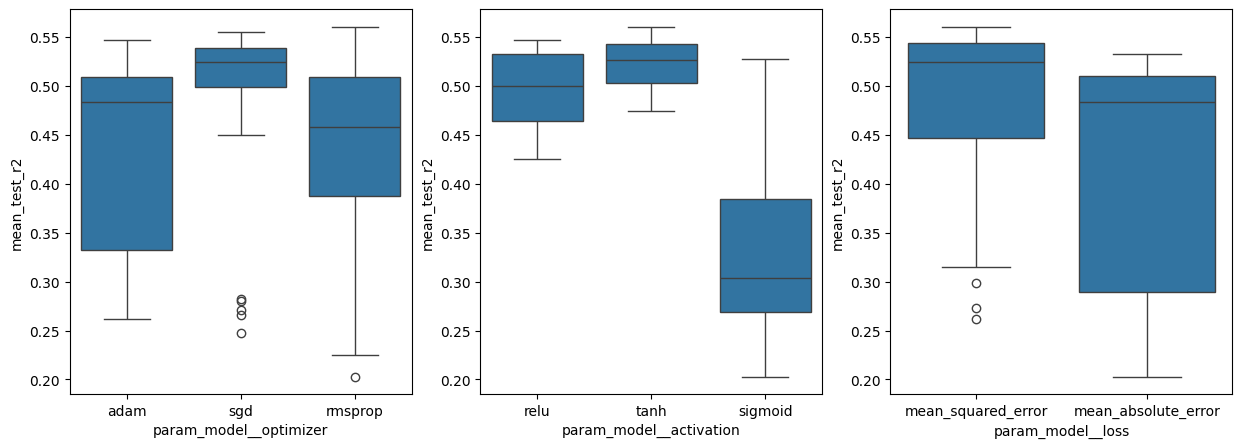

In [146]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.boxplot(data=keras_reg_cv_results, x='param_model__optimizer', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=keras_reg_cv_results, x='param_model__activation', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=keras_reg_cv_results, x='param_model__loss', y='mean_test_r2', ax=ax[2])

In [137]:
keras_reg_scores_test

,mean_absolute_error,mean_squared_error,r2
0,-1.565574,-4.785153,0.554139
1,-1.636749,-4.648068,0.548778
2,-1.486094,-4.453310,0.566127
3,-1.707115,-5.045925,0.515527
4,-1.458941,-4.225809,0.587720


In [145]:
keras_reg_estimators

[KerasRegressor(
 	model=<function create_model at 0x000001CA86AF6CA0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=tanh
 	model__layers=3
 	model__loss=mean_squared_error
 	model__neurons=40
 	model__optimizer=rmsprop
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001CA86AF6CA0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	model__activation=relu
 	model__layers=3
 	model__loss=mean_squared_error
 	model__neurons=40
 	model__optimizer=sgd
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001CA86AF6CA0>
 	build_fn=None
 	warm_start=False
 	random_s

In [149]:
keras_reg_param_2 = {
    'batch_size': [10, 20],
    'epochs': [20],     
    'model__optimizer': ['rmsprop'], 
    'model__activation': ['tanh'],
    'model__loss': ['mean_squared_error'],
    'model__layers': [2, 3],
    'model__neurons': [20, 40, 80, 120],
}
model_keras_reg_2 = KerasRegressor(model=create_model, verbose=0)
keras_reg_estimators_2, keras_reg_scores_train_2, keras_reg_scores_test_2, keras_reg_cv_results_2 = train(features, targets, model_keras_reg_2, keras_reg_param_2, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_model__neurons', ylabel='mean_test_r2'>

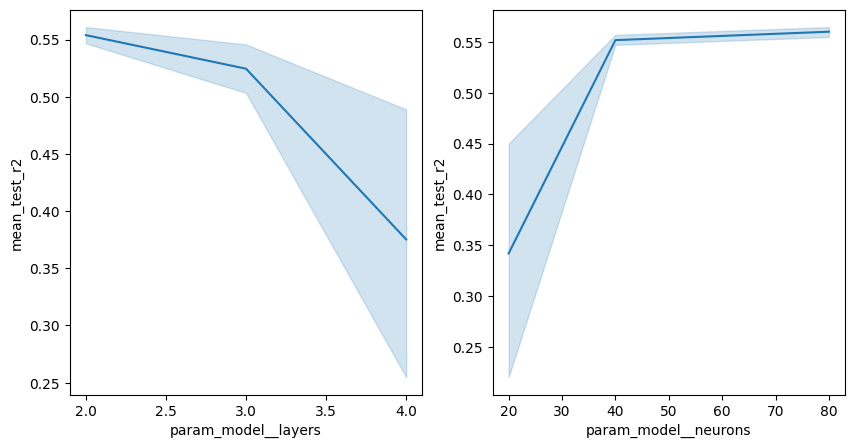

In [148]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_reg_cv_results_2, x='param_model__layers', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=keras_reg_cv_results_2, x='param_model__neurons', y='mean_test_r2', ax=ax[1])

In [142]:
keras_reg_scores_test_2

,mean_absolute_error,mean_squared_error,r2
0,-1.496802,-4.798480,0.552897
1,-1.490012,-4.558917,0.557433
2,-1.508706,-4.390185,0.572277
3,-1.507040,-4.476661,0.570184
4,-1.448611,-4.585916,0.552587


In [144]:
keras_reg_estimators_2

[KerasRegressor(
 	model=<function create_model at 0x000001CA86AF6CA0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=20
 	model__activation=tanh
 	model__layers=2
 	model__loss=mean_squared_error
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001CA86AF6CA0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=20
 	model__activation=tanh
 	model__layers=3
 	model__loss=mean_squared_error
 	model__neurons=80
 	model__optimizer=rmsprop
 ),
 KerasRegressor(
 	model=<function create_model at 0x000001CA86AF6CA0>
 	build_fn=None
 	warm_start=False
 	rand